In [1]:
!git clone https://github.com/FedorZaitsev/VKR25
%cd VKR25

Cloning into 'VKR25'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 130 (delta 47), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (130/130), 33.30 KiB | 4.76 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/kaggle/working/VKR25


In [2]:
import os

config = {
    'SEED' : 228,
    
    'BOS_TOKEN' : 4096,
    'EOS_TOKEN' : 4097,
    'INP_PAD_TOKEN' : 4098,
    'TAR_PAD_TOKEN' : -100,
    'VOCAB_SIZE' : 4099,
    'MAX_LENGTH' : 256,
    'OVERLAP' : 64,
    
    'NUM_WORKERS' : 4,
    'BATCH_SIZE' : 16,

    'ACCUM_STEPS' : 1,
}

for key, value in config.items():
    os.environ[key] = str(value)

In [3]:
import torch
import random
import numpy as np

device = 'cpu'
root_dir = '/kaggle/input/groove-tokens'

torch.manual_seed(config['SEED'])
random.seed(config['SEED'])
np.random.seed(config['SEED'])

In [4]:
from data import data

sequences = data.read_sequences(root_dir)
train_dataset, valid_dataset = data.get_train_val_dataset(sequences)

train_loader = data.get_loader(train_dataset)
valid_loader = data.get_loader(valid_dataset)

0it [00:00, ?it/s]/kaggle/working/VKR25/data/data.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sequences[i] = torch.load(filename, map_location=device).permute(2, 0,

In [5]:
from models.transformer_model import TransformerModel

In [6]:
import torch.nn as nn
from torch.optim import Adam, AdamW, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from transformers import get_cosine_schedule_with_warmup

In [7]:
model = torch.load('/kaggle/input/transformer/pytorch/default/1/checkpoint_400.pt', map_location=device)

/tmp/ipykernel_31/1928821762.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/input/transformer/pytorch/default/1/checkpoint_400.pt', map_loca

In [8]:
model = model.eval()

In [9]:
for x, y in train_loader:
    break

In [58]:
src = x[:, :].to(device)
mask = model.generate_square_subsequent_mask(src.shape[1]).to(device)

In [59]:
import math

src = model.embedding(src) * math.sqrt(model.d_model)
src = model.pos_encoder(src)
src = src.permute(1, 0, 2)

In [60]:
attn = []

for i in range(6):
    attn.append(model.transformer.layers[i].self_attn(src, src, src, average_attn_weights=False)[1])
    src = model.transformer.layers[i](src)

In [13]:
!git clone https://github.com/jishengpeng/WavTokenizer
%cd WavTokenizer
!wget https://huggingface.co/novateur/WavTokenizer-medium-music-audio-75token/resolve/main/wavtokenizer_medium_music_audio_320_24k_v2.ckpt
!wget https://huggingface.co/novateur/WavTokenizer-medium-music-audio-75token/resolve/main/wavtokenizer_mediumdata_music_audio_frame75_3s_nq1_code4096_dim512_kmeans200_attn.yaml

Cloning into 'WavTokenizer'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 200 (delta 65), reused 37 (delta 35), pack-reused 84 (from 1)
Receiving objects: 100% (200/200), 469.31 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/kaggle/working/VKR25/WavTokenizer
--2025-04-25 20:32:44--  https://huggingface.co/novateur/WavTokenizer-medium-music-audio-75token/resolve/main/wavtokenizer_medium_music_audio_320_24k_v2.ckpt
Resolving huggingface.co (huggingface.co)... 18.244.202.118, 18.244.202.68, 18.244.202.73, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/f8/d8/f8d8b97f33126a1e3a4c3ffe2e6af86c26776cfa33aee1294672329b62115562/078d11581aa10cc91572bfcff7ef00b71d8e24c4c359e98f9194a1a9d21ae8a8?response-content-disposition=inline%3B+filename*%3DUTF-

In [14]:
from encoder.utils import convert_audio
import torchaudio
import torch
from decoder.pretrained import WavTokenizer

config_path = "/kaggle/working/VKR25/WavTokenizer/wavtokenizer_mediumdata_music_audio_frame75_3s_nq1_code4096_dim512_kmeans200_attn.yaml"
model_path = "/kaggle/working/VKR25/WavTokenizer/wavtokenizer_medium_music_audio_320_24k_v2.ckpt"

wavtokenizer = WavTokenizer.from_pretrained0802(config_path, model_path)
wavtokenizer = wavtokenizer.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/kaggle/working/VKR25/WavTokenizer/decoder/pretrained.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_onl

In [15]:
def decode(x, name='example.wav'):
    audio_tokens = x[torch.where(x < 4096)[0]].unsqueeze(0).to(device)
    features = wavtokenizer.codes_to_features(audio_tokens)
    bandwidth_id = torch.tensor([0], device=device)
    audio_out = wavtokenizer.decode(features, bandwidth_id=bandwidth_id)
    torchaudio.save(name, audio_out.cpu(), sample_rate=24000, encoding='PCM_S', bits_per_sample=16)

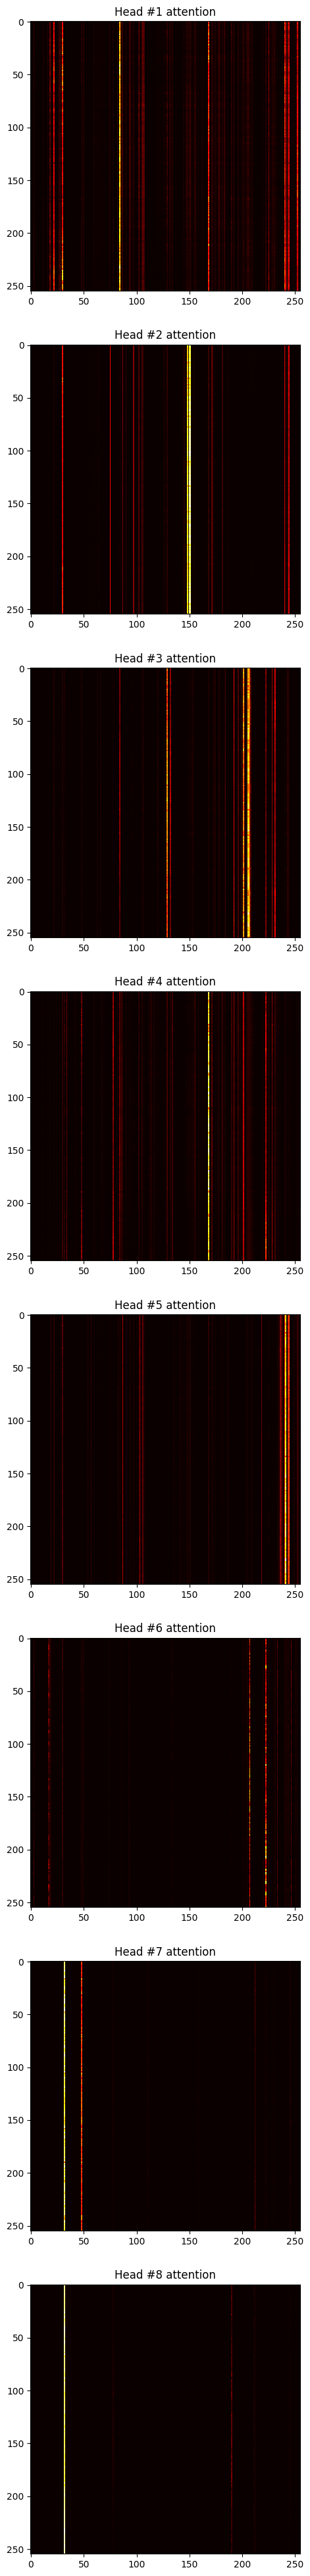

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(8, 1, figsize=(50, 50))
for i in range(8):
    ax[i].imshow(attn[5][0][i].detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    ax[i].title.set_text(f'Head #{i + 1} attention')
plt.show()

In [17]:
decode(x[0])

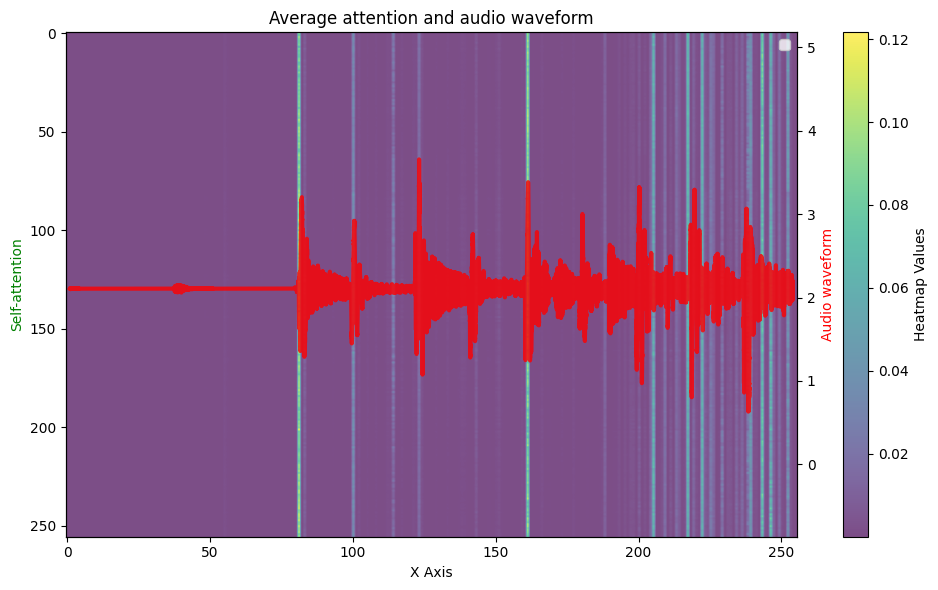

In [123]:
import scipy.io
import scipy.io.wavfile

i = 12
decode(x[i])

myAudioFilename = '/kaggle/working/VKR25/WavTokenizer/example.wav'  #  plot this wav file     ~/audio/aaa.wav

dataset_path = os.path.join(os.environ['HOME'], 'audio') # homedir -> audiodir -> my wav files
wavedata = os.path.join(dataset_path, myAudioFilename)
   
sampleRate, audioBuffer = (scipy.io.wavfile.read(wavedata))

sampleRate, audioBuffer = np.int64(sampleRate), np.int64(audioBuffer)

plt.figure(figsize=(10, 6))
# Create the line plot on top
audioBufferNorm = ((audioBuffer - audioBuffer.min()) / (audioBuffer.max() - audioBuffer.min())) * 128 + 64

im = plt.imshow((attn[5][i].detach().cpu().numpy()).mean(axis=0), aspect='auto', cmap='viridis', alpha=0.7)
plt.colorbar(im, label='Heatmap Values')

length = (x[i] < 4096).sum().item()
time = np.arange(1,length-0, (length-1) / len(audioBuffer)) #time vector
plt.plot(time,audioBufferNorm, 
         color='red', linewidth=3, alpha=0.8, 
         label='Correlated Line')

ax = plt.gca()
ax.set_xlabel('X Axis')
ax.set_ylabel('Self-attention', color='green')

ax2 = ax.twinx()
ax2.set_ylabel('Audio waveform', color='red')
ax2.set_ylim(line_data.min(), line_data.max())  # Original line scale


# Adjust layout to prevent overlap
plt.title('Average attention and audio waveform')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('example.png')
plt.show()